In [1]:
#Necessary imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import tensorflow as tf

<h2>Creating Mask :-

In [2]:
#The below lines of code is used to create a scratched image from a normal image by using Sketcher class. Finally, the scratched
#image and the respective mask will be stored.

class Sketcher:
    def __init__(self, windowname, dests, colors_func):
        self.prev_pt = None
        self.windowname = windowname
        self.dests = dests
        self.colors_func = colors_func
        self.dirty = False
        self.show()
        cv2.setMouseCallback(self.windowname, self.on_mouse)

    def show(self):
        cv2.imshow(self.windowname, self.dests[0])
        cv2.imshow(self.windowname+": Mask",self.dests[1])
        
    def on_mouse(self, event, x, y, flags, param):
        pt = (x,y)
        if event == cv2.EVENT_LBUTTONDOWN:
            self.prev_pt = pt
        
        elif event == cv2.EVENT_LBUTTONUP:
            self.prev_pt = None
            
        if self.prev_pt and flags & cv2.EVENT_FLAG_LBUTTON:
            for dst, color in zip(self.dests, self.colors_func()):
                cv2.line(dst, self.prev_pt, pt, color, 2)
            self.dirty = True
            self.prev_pt = pt
            self.show()
            

def main():
    print("Keys: ")
    print("r - reset the inpaint mask")
    print("ESC - exit")

    #Read image in color mode
    img = cv2.imread("data/ColorLadder.png", cv2.IMREAD_COLOR)

    if img is None:
        print('Failed to load image file: {}'.format(args["image"]))
        return
    
    img_mask = img.copy()

    inpaintMask = np.zeros(img.shape[:2], np.uint8)

    sketch = Sketcher('image',[img_mask, inpaintMask], lambda :((255.,0.,0.), 255.))

    while True:
        ch = cv2.waitKey(0)

        if ch == 27:
            #saving the marked image
            cv2.imwrite("data/Color_Ladder_Mark.png",img_mask)
            #saving the binary mask of the marked image
            cv2.imwrite("data/Color_Ladder_Mask.png",inpaintMask)
            break

        if ch == ord('r'):
            img_mask[:] = img
            inpaintMask[:]=0
            sketch.show()

if __name__ == '__main__':
    main()
    cv2.destroyAllWindows()

Keys: 
r - reset the inpaint mask
ESC - exit


<h2>Different Functions Definations :-

In [3]:
def readImage(path):
    """
    reading and zero padding the image
    
    path  :- path where the image exists.
    """
    #read the image from path
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    
    #normalize the values between 0 to 1
    image = image/255.0
    
    #find image's width, height and channel
    width = image.shape[0]
    height = image.shape[1]
    channel = image.shape[2]
    
    #padding the image so that every every corner can be equally learned
    padded_image = np.zeros((width+2, height+2, channel))
    padded_image[1:-1, 1:-1, :] = image
    return padded_image

In [4]:
def splitImage(image, n, mask):
    """
    this function divides the image into small pieces
    
    image :- image with mark (Scratched Image).
    n     :- size of small piece of an image (size in which we want to divide an image)
    mask  :- binary mask of the image.
    """
    #list which stores all the fined portion of an image
    fined_parts = []
    
    #find width and height of image having mark.
    width = image.shape[0]
    height = image.shape[1]
    
    #hover over the binary mask to find all the fined parts (of size n*n) of image
    for x in range(0,width-(n-1),1):
        for y in range(0,height-(n-1),1):
            #find a (n*n) portion of the mask to check whether it is having any white pixel
            v = mask[x:x+n,y:y+n]
            #if all the pixel values are zeros then the respective part of the image is a fined part (without mark)
            if np.count_nonzero(v) == 0:
                fined_parts.append(image[x:x+n, y:y+n, :])
    
    fined_parts = np.array(fined_parts,dtype=np.float64)
    return fined_parts

In [5]:
def addNoise(fined_parts):
    """
    add few noise to the fined part of the image so that it won't disregard the noise.
    
    fined_parts :- numpy array of all the fined small portion of the image.
    """
    #find the height, width & channel of the small fined portion of the image.
    height,width,channel = fined_parts.shape[1:]

    #iterate over the array of fined_part and add some noise ( Convert some of the pixels to zeros )
    for i in range(fined_parts.shape[0]):
        circle_img = np.ones((height,width),np.uint8)
        x = np.random.randint(0, height)
        y = np.random.randint(0, width)
        cv2.circle(circle_img,(x,y),1,0,thickness = -1)
        masked_data = cv2.bitwise_and(fined_parts[i], fined_parts[i], mask=circle_img)

        fined_parts[i] = masked_data
    
    return fined_parts

In [6]:
def prepareModel(n):
    """
    prepare the structure of the model ( deep convolutional autoencoder )
    
    we are gradually increasing the number of channels and size of kernels, so that our model can understand 
    what features to learn and what to ignore.
    
    n :- input size of the model
    """
    #define input layer of the model
    inputs = tf.keras.layers.Input(shape=(n,n,3))
    
    #Encoder
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    x = tf.keras.layers.Conv2D(64, (4, 4), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    #bottleneck
    x = tf.keras.layers.Conv2D(128, (5, 5), activation='relu', padding='same')(x)
    
    #Decoder
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Conv2D(64, (4, 4), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
   
    #we are using sigmoid activation in the output layer, b'cus we want the values to lies between 0 to 1
    outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='sigmoid', padding='same')(x)
    
    #define the input and output layers of the model
    img_inpaint = tf.keras.models.Model(inputs, outputs)
    
    #compile the model to define the optimizer (ADAM), loss function (MEAN SQUARE ERROR) and metrics (ACCURACY)
    img_inpaint.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return img_inpaint

![title](imgs/MODEL.png)

<h2>Main Section (Read Image and find fined_parts and run model) :-

In [7]:
#read the image with scratches
path = "data/Color_Ladder_Mark.png"
img = readImage(path)

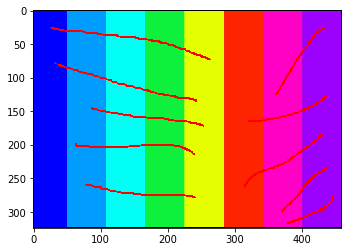

In [8]:
#plot the image using imshow() of matplotlib
plt.imshow(img)

In [9]:
#read the binary mask
mask_path = "data/Color_Ladder_Mask.png"
mask_1 = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

#add padding to the binary mask, so that the shape of binary mask will be equal to shape of image after padding.
width = mask_1.shape[0]
height = mask_1.shape[1]
mask = np.zeros((width+2, height+2))
mask[1:-1, 1:-1] = mask_1[:,:]

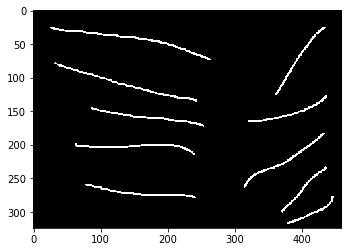

In [10]:
#plot the binary mask
plt.imshow(mask)
plt.gray()

In [11]:
#spliting image into 4*4 and finding the fined portions
n = 4
fined_parts = splitImage(img, n, mask)

In [12]:
#show the number fined parts
fined_parts.shape

(135644, 4, 4, 3)

In [13]:
#adding noise to the fined portions
x_train_noisy = fined_parts.copy()
x_train_noisy = addNoise(x_train_noisy)

In [14]:
#show the number of parts after adding noise
x_train_noisy.shape

(135644, 4, 4, 3)

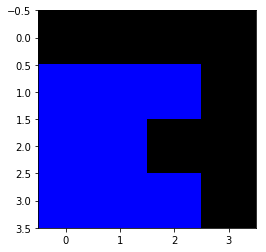

In [15]:
#plotting a part after adding noise
plt.imshow(x_train_noisy[10].reshape(4, 4, 3))

In [16]:
#clip the values of pixels of small pieces of images between 0 to 1 after adding noise
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

In [17]:
x_train_noisy.shape

(135644, 4, 4, 3)

In [18]:
fined_parts.shape

(135644, 4, 4, 3)

In [19]:
#prepare the structure of the model and compile the model
img_inpaint = prepareModel(4)

In [23]:
#fit or train the model
#you may increase or decrease the number of epochs after seeing result.
img_inpaint.fit(x_train_noisy, fined_parts, epochs=15, batch_size=100, shuffle=True )

Train on 144465 samples
Epoch 1/10
144465/144465 [==============================] - 94s 647us/sample - loss: 0.0052 - acc: 0.9465
Epoch 2/10
144465/144465 [==============================] - 92s 634us/sample - loss: 0.0024 - acc: 0.9664
Epoch 3/10
144465/144465 [==============================] - 99s 682us/sample - loss: 0.0018 - acc: 0.9693
Epoch 4/10
144465/144465 [==============================] - 93s 641us/sample - loss: 0.0015 - acc: 0.9759
Epoch 5/10
144465/144465 [==============================] - 97s 674us/sample - loss: 0.0013 - acc: 0.9804
Epoch 6/10
144465/144465 [==============================] - 96s 665us/sample - loss: 9.7449e-04 - acc: 0.9829
Epoch 7/10
144465/144465 [==============================] - 96s 666us/sample - loss: 7.6504e-04 - acc: 0.9842
Epoch 8/10
144465/144465 [==============================] - 95s 656us/sample - loss: 6.5506e-04 - acc: 0.9861
Epoch 9/10
144465/144465 [==============================] - 100s 694us/sample - loss: 5.6078e-04 - acc: 0.9871
Epoch

In [22]:
#testing the model ( give all the damaged small portion of image as input and output will be pasted in original image )
img_copy = img.copy()
mask_copy = mask.copy()

width = mask_copy.shape[0]
height = mask_copy.shape[1]

for x in range(0,width-3,1):
    for y in range(0,height-3,1):
        if np.count_nonzero(mask_copy[x:x+4, y:y+4]) >= 1:
            op = img_inpaint.predict(img_copy[x:x+4, y:y+4,:].reshape(1,4,4,3))
            img_copy[x:x+4, y:y+4,:] = op.reshape(4, 4, 3)
            mask_copy[x:x+4, y:y+4] = 0

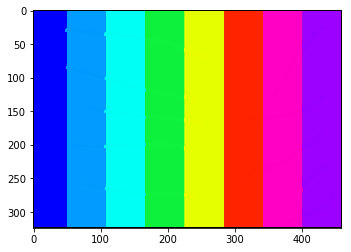

In [23]:
#plot the image after inpainting
plt.imshow(img_copy)

In [24]:
#showing the inpainted image in a different window using imshow() of opencv
cv2.imshow("inpainted_image", img_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [25]:
#save the image after inpainting
img_copy *= 255.0
cv2.imwrite("data/Color_Ladder_OP.png",img_copy)

True

In [31]:
#save the model ( save the weights of model )
img_inpaint.save_weights("weights/img_inpt_color_ladder_model.h5")

In [20]:
#load the model if required
img_inpaint.load_weights("weights/img_inpt_color_ladder_model.h5")